In [2]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [3]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 43 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [4]:
with open('../output/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

In [5]:
df['NonCriminal'] = df['Criminality'] == 'NC'

# Airport report

For a given airport IATA code represented in the ICE Air data, output a uniform set of variables, tables, and figures.

In [6]:
airport = 'KBFI'
airport_name = airport_dict[airport]

In [7]:
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport

In [8]:
pickup_df = df[pickup]
dropoff_df = df[dropoff]

In [9]:
pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

In [10]:
unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
print(f'{unique_pickups} pickups, {unique_dropoffs} dropoffs.')

34443 pickups, 15191 dropoffs.


In [11]:
weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
monthly_pickup_flights = pickup_df['MissionID'].resample('M').nunique()
monthly_dropoff_flights = dropoff_df['MissionID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_pickup_flights = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_flights = dropoff_df['MissionID'].resample('AS-OCT').nunique()

# Annual trends (by fiscal year)

In [18]:
annual_pickups['2010':'2018']

MissionDate
2010-10-01    6629
2011-10-01    5664
2012-10-01    4797
2013-10-01    3955
2014-10-01    2732
2015-10-01    3129
2016-10-01    3390
2017-10-01    3495
2018-10-01     652
Freq: AS-OCT, Name: Total Pickups, dtype: int64

In [19]:
annual_dropoffs['2010':'2018']

MissionDate
2010-10-01     552
2011-10-01    1175
2012-10-01    2153
2013-10-01    2247
2014-10-01    1926
2015-10-01    2737
2016-10-01    1487
2017-10-01    2504
2018-10-01     410
Freq: AS-OCT, Name: Total Dropoffs, dtype: int64

In [20]:
annual_pickups.rename('Total Pickups', inplace=True)
annual_dropoffs.rename('Total Dropoffs', inplace=True)

MissionDate
2010-10-01     552
2011-10-01    1175
2012-10-01    2153
2013-10-01    2247
2014-10-01    1926
2015-10-01    2737
2016-10-01    1487
2017-10-01    2504
2018-10-01     410
Freq: AS-OCT, Name: Total Dropoffs, dtype: int64

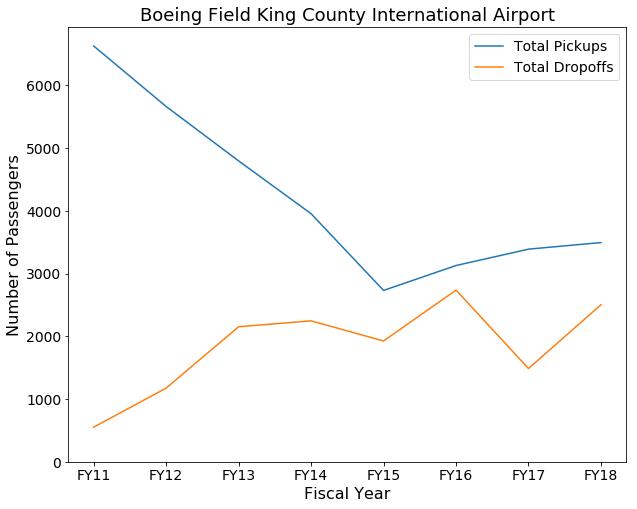

In [21]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{airport_name}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig('../output/ICEFlights.png', dpi=100)
    return fig, ax

plot = pickup_dropoff_trend([annual_pickups['2010':'2017'], annual_dropoffs['2010':'2017']]);

# Annual pickup rate, by criminal conviction status

In [22]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [23]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

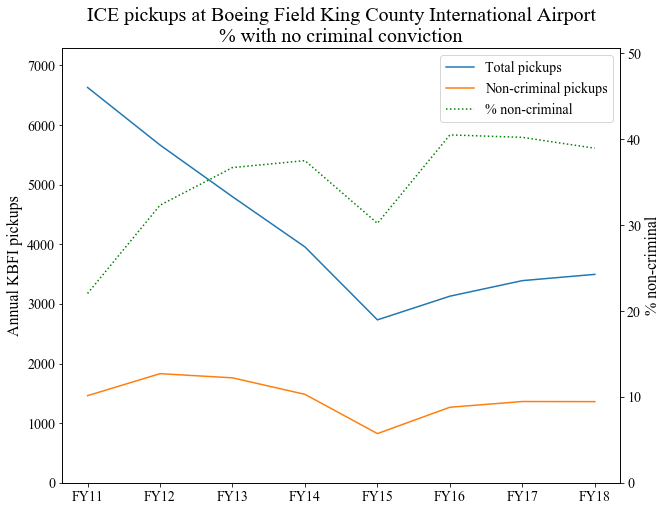

In [24]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Times New Roman")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

In [38]:
monthly_means = pd.DataFrame()
for year in range(2010, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_flights = monthly_pickup_flights[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_flights = monthly_dropoff_flights[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_flights':mean_pickup_flights,
                                          'monthly_mean_dropoff_flights':mean_dropoff_flights,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

In [40]:
monthly_means.round(2)

,monthly_mean_dropoff_flights,monthly_mean_dropoffs,monthly_mean_pickup_flights,monthly_mean_pickups
calendar_year,,,,
2010,4.00,39.33,7.67,512.67
2011,4.42,59.00,8.33,544.17
2012,3.92,115.42,4.83,450.17
2013,3.17,165.25,4.08,383.58
2014,3.83,161.92,3.92,300.00
2015,3.17,209.00,2.83,237.67
2016,4.17,231.50,4.50,264.83
2017,3.50,120.92,4.25,288.50
2018,3.75,193.08,4.17,273.17


In [207]:
# Change groupby to `dropoff_df` to get table/figure of dropoff nationalities
g = dropoff_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [208]:
country_of_citizenship_by_year.set_index('FY', inplace=True)

In [209]:
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

In [210]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

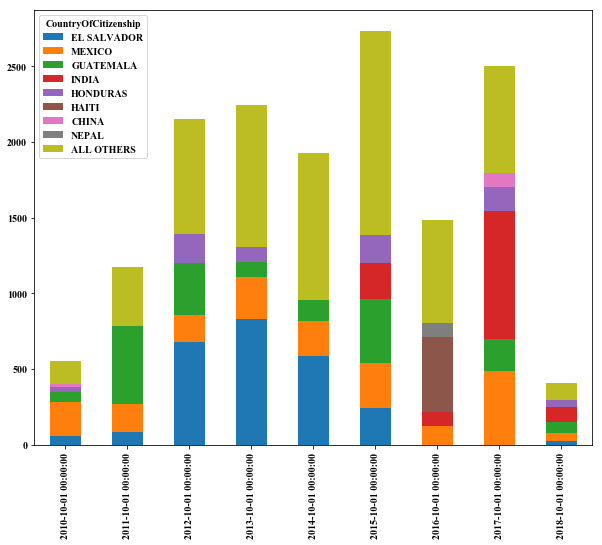

In [211]:
pivot = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)
cols = list(pivot.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
pivot = pivot[cols]

fig = pivot.plot(kind='bar', stacked=True, figsize=(10, 8))

In [212]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)